# 其他因子

* 現金股利殖利率
* EBITDA
* 現金流量比率
* 槓桿比率
* 總資產週轉次數

In [1]:
# initail
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union

client = pymongo.MongoClient()
db1 = client['Index']

In [2]:
class Chast:

    def __init__(self, client, db_name='Fields'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1]


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(7, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'][self.results['BS'] < 0].count(axis=1), color='green')
            ax[2].set_title('空單持有檔數')
            ax[3].plot(self.results['BS'][self.results['BS'] > 0].count(axis=1), color='red')
            ax[3].set_title('多單持有檔數')
        if 'HOLDING' in keys:
            ax[4].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[4].set_title('累計市值')
            ax[4].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[5].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[5].grid(True)
            ax[5].set_title('Rolling Sharpe Ratio')
            ax[5].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[6].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[6].grid(True)
            ax[6].set_title('Capital')
            ax[6].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, elements,
     start: Union[datetime.datetime, None]=None, 
     end: Union[datetime.datetime, None]=None):
        """
        elements: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        
        if type(elements) != list:
            self.data[elements] = pd.DataFrame(self.db[elements].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
        else:
            for e in elements:
                self.data[e] = pd.DataFrame(self.db[e].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca

    def creat_to_daily(self, df: pd.DataFrame):
        n = pd.DataFrame(columns=self.data['還原收盤價'].columns, index=self.data['還原收盤價'].index.union(df.index))
        for i in df.index:
            for c in df.columns:
                n.at[i, str(c)] = df.at[i, c]
        return n.fillna(method='ffill').loc[self.data['還原收盤價'].index, self.data['還原收盤價'].columns]

In [3]:
# Load Data
np.seterr(divide='ignore')
chast = Chast(client, 'Fields')
# TODO: 這邊更改成近四季試試
getting_list = [
    'EBITDA_Q',
    '槓桿比率_Q',
    '現金股利殖利率_Y',
    '現金股利殖利率_Q',
    '現金流量比率_Q',
    '總資產週轉次數_Y',
    '收盤價',
    '還原收盤價'
]
#getting_list = chast.db.list_collection_names()
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime(2013, 10, 11)
#end = datetime.datetime.today()
# 原始資料
chast.get_from_mongo(getting_list, start, end)
chast.set_data('收盤價', chast.data['收盤價'].fillna(method='ffill'))
chast.set_data('還原收盤價', chast.data['還原收盤價'].fillna(method='ffill'))
chast.set_data('MA60', chast.data['還原收盤價'].rolling(60).mean())
chast.set_data('MA120', chast.data['還原收盤價'].rolling(120).mean())
chast.set_data('大盤收盤價', pd.DataFrame(db1['TWA00'].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, '還原收盤價': 1})).set_index('日期').dropna(how='all'))

# 調整後資料
log收盤價 = chast.data['還原收盤價'].copy()
for c in log收盤價.columns:
    if log收盤價.loc[:, c].sum() != 0:
        log收盤價.loc[:, c] = np.log(log收盤價.loc[:, c])
chast.set_data('log收盤價', log收盤價)
chast.set_data('EBITDA_daily', chast.creat_to_daily(chast.data['EBITDA_Q'].rolling(4).sum().pct_change().replace([np.inf, -np.inf], np.nan)))
chast.set_data('槓桿比率_daily', chast.creat_to_daily(chast.data['槓桿比率_Q'].rolling(4).sum()))
chast.set_data('現金股利殖利率_dailyY', chast.creat_to_daily(chast.data['現金股利殖利率_Y']))
chast.set_data('現金股利殖利率_dailyQ', chast.creat_to_daily(chast.data['現金股利殖利率_Q'].rolling(4).sum()))
chast.set_data('現金流量比率_daily', chast.creat_to_daily(chast.data['現金流量比率_Q'].rolling(4).sum()))
chast.set_data('總資產週轉次數_daily', chast.creat_to_daily(chast.data['總資產週轉次數_Y']))
# 調整讓所有資料的columns一樣
idx_, col_ = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns

for k in chast.data.keys():
    if k.__contains__('_Q') or k.__contains__('_Y'):
        continue
    if k in ['大盤收盤價']:
        idx_ = idx_.intersection(chast.data[k].index)
    else:
        idx_ = idx_.intersection(chast.data[k].index)
        col_ = col_.intersection(chast.data[k].columns)
for k in chast.data.keys():
    if k.__contains__('_Q') or k.__contains__('_Y'):
        continue
    if k in ['大盤收盤價']:
        chast.data[k] = chast.data[k].loc[idx_]
    else:
        chast.data[k] = chast.data[k].loc[idx_, col_]


In [4]:
# 極端值處理
for n in ['EBITDA_daily', '槓桿比率_daily', '現金股利殖利率_dailyY', '現金股利殖利率_dailyQ', '現金流量比率_daily', '總資產週轉次數_daily']:
    for idx, row in chast.data[n].iterrows():
        mask = row[row > row.quantile(.99)].index
        chast.data[n].loc[idx, mask] = row.quantile(.99)
        mask = row[row < row.quantile(.01)].index
        chast.data[n].loc[idx, mask] = row.quantile(.01)


In [82]:
{k: v.shape for k, v in chast.data.items()}
#{k: v.index[0] for k, v in chast.data.items()}

{'EBITDA_Q': (39, 2211),
 '槓桿比率_Q': (39, 2211),
 '現金股利殖利率_Y': (10, 2211),
 '現金股利殖利率_Q': (20, 2211),
 '現金流量比率_Q': (39, 2211),
 '總資產週轉次數_Y': (10, 2211),
 '收盤價': (2428, 2211),
 '還原收盤價': (2428, 2211),
 'MA60': (2428, 2211),
 'MA120': (2428, 2211),
 '大盤收盤價': (2428, 1),
 'log收盤價': (2428, 2211),
 'EBITDA_daily': (2428, 2211),
 '槓桿比率_daily': (2428, 2211),
 '現金股利殖利率_dailyY': (2428, 2211),
 '現金股利殖利率_dailyQ': (2428, 2211),
 '現金流量比率_daily': (2428, 2211),
 '總資產週轉次數_daily': (2428, 2211)}

In [80]:
long = (chast.data['槓桿比率_daily'] > 300) &\
    (chast.data['EBITDA_daily'] < 0) &\
    (chast.data['現金股利殖利率_dailyY'] < 1) &\
    (chast.data['現金流量比率_daily'] < 25 ) &\
    (chast.data['總資產週轉次數_daily'] < 0.5 )
long = long.shift(1)

In [81]:
short = (chast.data['EBITDA_daily'] > 0) &\
    (chast.data['槓桿比率_daily'] < 300) &\
    (chast.data['現金股利殖利率_dailyY'] > 3) &\
    (chast.data['現金流量比率_daily'] > 30 ) &\
    (chast.data['總資產週轉次數_daily'] > 1 )
short = short.shift(1)

In [82]:
print((chast.data['EBITDA_daily'] > 0.5).sum(axis=1).mean())
print((chast.data['槓桿比率_daily'] < 150).sum(axis=1).mean())
print((chast.data['現金股利殖利率_dailyY'] > 4).sum(axis=1).mean())
print((chast.data['現金流量比率_daily'] > 45 ).sum(axis=1).mean())
print((chast.data['總資產週轉次數_daily'] > 1.5 ).sum(axis=1).mean())


print('\n--')
print((chast.data['EBITDA_daily'] < -0.5).sum(axis=1).mean())
print((chast.data['槓桿比率_daily'] > 450).sum(axis=1).mean())
print((chast.data['現金股利殖利率_dailyY'] == 0).sum(axis=1).mean())
print((chast.data['現金流量比率_daily'] < 10 ).sum(axis=1).mean())
print((chast.data['總資產週轉次數_daily'] < 0.25 ).sum(axis=1).mean())

101.71457990115321
246.0704283360791
416.7545304777595
341.2207578253707
169.8014827018122

--
109.60337726523888
286.8249588138386
543.7425864909391
351.6355024711697
140.80189456342669


EBITDA_Q mean: -0.0024 std: -0.0658  
槓桿比率_Q mean: 0.0219 std: 0.4822  
現金股利殖利率_Y mean: -0.0074 std: -0.1151  
現金流量比率_Q mean: -0.0117 std: -0.3198  
總資產週轉次數_Y mean: -0.0133 std: -0.1868  

In [83]:

月末買 = long.groupby(pd.Grouper(freq='Q')).tail(1)
月末賣 = short.groupby(pd.Grouper(freq='Q')).tail(1)
股票名稱轉換 = pd.DataFrame(client['Index']['股票名稱轉換'].find({}, {'_id': 0})).to_dict('records')[0]

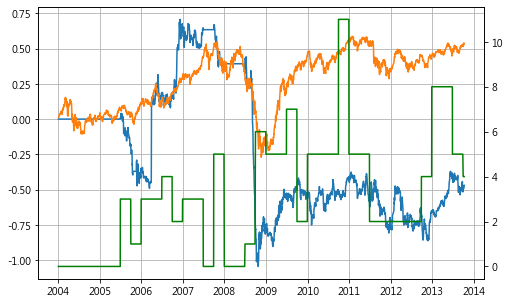

當前持倉:  {'2528': '皇普', '5321': '美而快', '6125': '廣運', '9906': '欣巴巴'}
Sharpe Ratio: -0.52
MDD: -175.04 %
日期
2004-12-31        0.0%
2005-12-31     -37.77%
2006-12-31      99.57%
2007-12-31     -22.61%
2008-12-31    -114.99%
2009-12-31      23.11%
2010-12-31      10.59%
2011-12-31     -36.07%
2012-12-31      12.29%
2013-12-31       18.9%
Freq: A-DEC, dtype: object


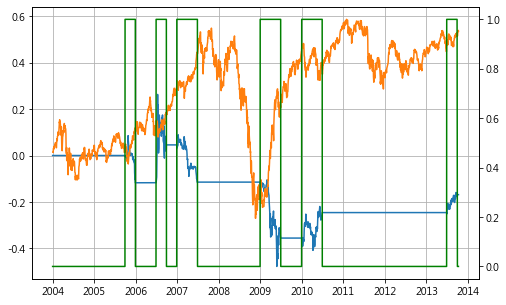

當前持倉:  {}
Sharpe Ratio: -1.17
MDD: -74.02 %
日期
2004-12-31       0.0%
2005-12-31    -11.73%
2006-12-31     14.85%
2007-12-31    -14.58%
2008-12-31     -2.01%
2009-12-31    -22.64%
2010-12-31     11.54%
2011-12-31       0.0%
2012-12-31       0.0%
2013-12-31      7.71%
Freq: A-DEC, dtype: object


In [84]:
def 轉日資料處理(df: pd.DataFrame):
    轉日 = pd.DataFrame(index=chast.data['還原收盤價'].index, columns=chast.data['還原收盤價'].columns)
    for i in df.index:
        for c in df.columns:
            轉日.at[i, c] = df.at[i, c]
    轉日 = 轉日.sort_index().fillna(method='ffill')
    return 轉日

大盤損益 = chast.data['大盤收盤價'].pct_change().cumsum()

def 損益(轉日: pd.DataFrame, 買賣):
    日損益 = log收盤價.shift(-1) - log收盤價
    換股日損益 = 轉日 * 日損益 * 買賣
    進場 = 轉日 - 轉日.shift(1)
    出場 = 轉日.shift(-1) - 轉日
    費用 = 轉日.copy()
    費用.iloc[:] = 0
    費用[進場 > 0] = 0.001425
    費用[出場 < 0] = 0.004425
    換股日平均損益 = (換股日損益-費用).sum(axis=1) / 轉日.sum(axis=1)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax1 = ax.twinx()
    ax.plot(換股日平均損益.fillna(0).cumsum())
    ax.plot(大盤損益)
    ax1.plot(轉日.sum(axis=1), color='green')
    ax.grid(True)
    plt.show()
    持倉 = sorted(轉日.iloc[-1][轉日.iloc[-1] >= 1].index)
    print('當前持倉: ', {v: 股票名稱轉換[v] for v in 持倉})
    length = len(換股日平均損益.dropna() / 252)
    sr = (換股日平均損益.fillna(0).cumsum().mean()) / (換股日平均損益.fillna(0).cumsum().std())
    def maxdrawdown(se):
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        return pd.Series(mdd_, index=se.index, name='MDD')
    mdd = min(maxdrawdown(換股日平均損益.fillna(0).cumsum()))
    print('Sharpe Ratio: {:.2f}'.format(sr))
    print('MDD: {:.2f} %'.format(mdd*100))
    print((換股日平均損益.fillna(0).groupby(pd.Grouper(freq='1y')).sum() * 100).round(2).astype(str) + '%')
    return 換股日平均損益

轉日月末買 = 轉日資料處理(月末買)
轉日月末賣 = 轉日資料處理(月末賣)
日買平均 = 損益(轉日月末買, 1)
日賣平均 = 損益(轉日月末賣, -1)


日期
2004-12-31       0.0%
2005-12-31     -49.5%
2006-12-31    114.43%
2007-12-31    -37.18%
2008-12-31    -117.0%
2009-12-31      0.47%
2010-12-31     22.13%
2011-12-31    -36.07%
2012-12-31     12.29%
2013-12-31     26.61%
Freq: A-DEC, dtype: object


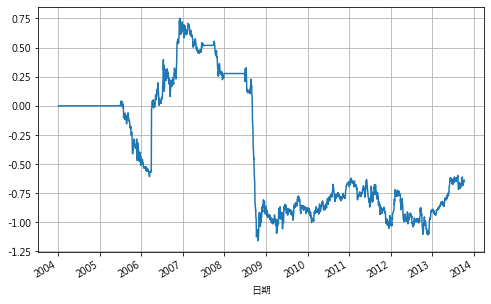

Sharpe Ratio: -0.71
MDD:          -191.06 %


In [85]:
pf = (日買平均.fillna(0) + 日賣平均.fillna(0)).cumsum()
pf.plot(figsize=(8, 5), grid=True)#.groupby(pd.Grouper(freq='1y')).sum()
print(((日買平均.fillna(0) + 日賣平均.fillna(0)).groupby(pd.Grouper(freq='1y')).sum()*100).round(2).astype(str) + '%')
sr = (pf.mean()) / (pf.std())
def maxdrawdown(se):
    mdd = 0
    mdd_ = list()
    h = 0
    for i in se:
        if i > h:
            h = i
        mdd = i - h
        mdd_.append(mdd)
    return pd.Series(mdd_, index=se.index, name='MDD')
mdd = min(maxdrawdown(pf))
plt.show()
print('Sharpe Ratio: {:.2f}'.format(sr))
print('MDD:          {:.2f} %'.format(mdd*100))


In [85]:
day = -2
多單持倉 = {v: 股票名稱轉換[v] for v in sorted(轉日月末買.iloc[day][轉日月末買.iloc[day] >= 1].index)}
空單持倉 = {v: 股票名稱轉換[v] for v in sorted(轉日月末賣.iloc[day][轉日月末賣.iloc[day] >= 1].index)}

#{v: 股票名稱轉換[v] for v in sorted(轉日月末買.iloc[-1][轉日月末買.iloc[-1] >= 1].index)}
多單內容 = pd.DataFrame(list(zip(多單持倉.keys(), 多單持倉.values(), chast.data['股價淨值比'].iloc[-1][多單持倉.keys()],
            chast.data['本益比(近四季)'].iloc[-1][多單持倉.keys()],
            chast.data['EPS_Q'].rolling(4).sum().iloc[-1][多單持倉.keys()],
            chast.data['殖利率'].iloc[-1][多單持倉.keys()])), columns=['商品代號', '商品名稱', 'PB', 'PE', 'EPS', '殖利率'], index=range(len(多單持倉)))
空單內容 = pd.DataFrame(list(zip(空單持倉.keys(), 空單持倉.values(), chast.data['股價淨值比'].iloc[-1][空單持倉.keys()],
            chast.data['本益比(近四季)'].iloc[-1][空單持倉.keys()],
            chast.data['EPS_Q'].rolling(4).sum().iloc[-1][空單持倉.keys()],
            chast.data['殖利率'].iloc[-1][空單持倉.keys()])), columns=['商品代號', '商品名稱', 'PB', 'PE', 'EPS', '殖利率'], index=range(len(空單持倉)))

In [86]:
多單內容['XQ即時價格'] = [f"=@XQ|Quote!'{x}.TW-Price'" for x in 多單內容['商品代號']]
空單內容['XQ即時價格'] = [f"=@XQ|Quote!'{x}.TW-Price'" for x in 空單內容['商品代號']]
多單內容['XQ前日價格'] = [f"=@XQ|Quote!'{x}.TW-PreClose'" for x in 多單內容['商品代號']]
空單內容['XQ前日價格'] = [f"=@XQ|Quote!'{x}.TW-PreClose'" for x in 空單內容['商品代號']]

In [87]:
display(多單內容)
display(空單內容)


,商品代號,商品名稱,PB,PE,EPS,殖利率,XQ即時價格,XQ前日價格
0,2247,汎德永業,1.4500,12.4000,16.6400,5.8100,=@XQ|Quote!'2247.TW-Price',=@XQ|Quote!'2247.TW-PreClose'
1,2534,宏盛,0.8500,10.0000,2.4500,4.9100,=@XQ|Quote!'2534.TW-Price',=@XQ|Quote!'2534.TW-PreClose'
2,2702,華園,1.2400,1.7000,17.7800,4.3200,=@XQ|Quote!'2702.TW-Price',=@XQ|Quote!'2702.TW-PreClose'
3,3231,緯創,0.9100,8.1000,3.2900,8.2100,=@XQ|Quote!'3231.TW-Price',=@XQ|Quote!'3231.TW-PreClose'
4,3376,新日興,1.1100,13.3000,6.6900,5.6400,=@XQ|Quote!'3376.TW-Price',=@XQ|Quote!'3376.TW-PreClose'
5,5009,榮剛,1.5700,10.8000,2.9400,4.4100,=@XQ|Quote!'5009.TW-Price',=@XQ|Quote!'5009.TW-PreClose'
6,5534,長虹,1.1200,7.6000,9.4200,6.1300,=@XQ|Quote!'5534.TW-Price',=@XQ|Quote!'5534.TW-PreClose'
7,8401,白紗科,1.4100,9.5000,2.2900,7.9500,=@XQ|Quote!'8401.TW-Price',=@XQ|Quote!'8401.TW-PreClose'
8,9904,寶成,1.2300,5.8000,4.8100,5.4100,=@XQ|Quote!'9904.TW-Price',=@XQ|Quote!'9904.TW-PreClose'
9,9907,統一實,1.4300,10.6000,1.7000,5.5200,=@XQ|Quote!'9907.TW-Price',=@XQ|Quote!'9907.TW-PreClose'


,商品代號,商品名稱,PB,PE,EPS,殖利率,XQ即時價格,XQ前日價格
0,1732,毛寶,2.5400,117.9000,0.2500,1.2200,=@XQ|Quote!'1732.TW-Price',=@XQ|Quote!'1732.TW-PreClose'
1,1784,訊聯,1.8300,131.4000,0.2900,1.2500,=@XQ|Quote!'1784.TW-Price',=@XQ|Quote!'1784.TW-PreClose'
2,2371,大同,1.9100,18.7000,1.7600,0.0000,=@XQ|Quote!'2371.TW-Price',=@XQ|Quote!'2371.TW-PreClose'
3,3228,金麗科,21.3100,183.8000,1.3100,0.0000,=@XQ|Quote!'3228.TW-Price',=@XQ|Quote!'3228.TW-PreClose'
4,6283,淳安,2.7300,198.3000,0.1700,0.0000,=@XQ|Quote!'6283.TW-Price',=@XQ|Quote!'6283.TW-PreClose'
5,8440,綠電,2.6600,37.2000,1.0500,1.5400,=@XQ|Quote!'8440.TW-Price',=@XQ|Quote!'8440.TW-PreClose'


In [80]:
多單內容.to_excel(r'C:\Users\ChastLai\Documents\Python Scripts\Output\價值型股票\多單.xlsx', index=None)
空單內容.to_excel(r'C:\Users\ChastLai\Documents\Python Scripts\Output\價值型股票\空單.xlsx', index=None)


# TODO: 改成多空皆有
def backtesting(long_entry: pd.DataFrame, short_entry: pd.DataFrame, 優先買賣資料: pd.DataFrame, 優先買賣類型: bool,
    long_capital: int = 375000, short_capital: int = 700000, total_capital: int = 100000000):

    
    f_idx, f_col = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns
    # 製作空表格，用於計算時存值，最後set回去五個底線dataframe
    def make_df(idx, col):
        return pd.DataFrame(index=idx, columns=col)
    chast.set_data('20std', chast.data['還原收盤價'].rolling(20).std())
    
    bs = make_df(f_idx, f_col).fillna(0)
    com_ = make_df(f_idx, f_col).fillna(0)
    pf_ = make_df(f_idx, f_col).fillna(0)
    ep_ = make_df(f_idx, f_col).fillna(99999)
    ed_ = make_df(f_idx, f_col).fillna(f_idx[0])
    bs_ = make_df(f_idx, f_col).fillna(0)
    eh_ = make_df(f_idx, f_col).fillna(0)
    el_ = make_df(f_idx, f_col).fillna(99999)

    # 存前一根K的時間
    idx1 = f_idx[0]
    # 還原收盤價與收盤價的轉換
    transform = chast.data['收盤價'] / chast.data['還原收盤價']
    # 資金設定 1 億
    # per_capital = 250000
    # total_capital = 100000000
    capital = pd.Series([total_capital] * len(f_idx), index=f_idx)

    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    for idx, row in chast.data['還原收盤價'].iterrows():
        # 用at取代loc，聽說更快
        
        for col in row.index:
            bs_.at[idx, col] = bs.at[idx1, col]
            bs.at[idx, col] = bs.at[idx1, col]
            ep_.at[idx, col] = ep_.at[idx1, col]
            eh_.at[idx, col] = eh_.at[idx1, col]
            el_.at[idx, col] = el_.at[idx1, col]
            ed_.at[idx, col] = ed_.at[idx1, col]
            # 損益計算
        for col in row.index:
            # 多單進場
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] <= 0):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 多單加碼
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] >=1) & (bs_.at[idx1, col] != bs_.at[idx, col]):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * (bs_.at[idx, col] - bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
            # 多單出場   
            if (bs_.at[idx, col] <= 0) & (bs_.at[idx1, col] >= 1):
                com_.at[idx, col] += np.round((0.001425 + 0.003 + 0.003) * abs(bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)

            # 空單進場
            if (bs_.at[idx, col] <= -1) & (bs_.at[idx1, col] >= 0):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * abs(bs_.at[idx, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 空單加碼
            if (bs_.at[idx, col] <= -1) & (bs_.at[idx1, col] <= -1) & (bs_.at[idx1, col] != bs_.at[idx, col]):
                com_.at[idx, col] += np.round((0.001425 + 0.003) * abs(bs_.at[idx, col] - bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]

            # 空單出場   
            if (bs_.at[idx, col] >= 0) & (bs_.at[idx1, col] <= -1):
                com_.at[idx, col] += np.round((0.001425 + 0.003 + 0.003) * abs(bs_.at[idx1, col]) * 1000 * chast.data['收盤價'].at[idx, col], 2)
            
            # 損益計算
            if (bs_.at[idx1, col] != 0):
                pf_.at[idx, col] = np.round((chast.data['還原收盤價'].at[idx, col] - chast.data['還原收盤價'].at[idx1, col]) * transform.at[idx1, col] * bs_.at[idx1, col] * 1000, 2)
                if chast.data['還原收盤價'].at[idx, col] > eh_.at[idx, col]:
                    eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                if chast.data['還原收盤價'].at[idx, col] < el_.at[idx, col]:
                    el_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                    
        capital[idx] = capital[idx1]

        # 進場條件1
        long_mask = (bs.loc[idx, :] <= 0) & long_entry.loc[idx, :] &\
            (chast.data['20std'].loc[idx, :] >= 0.0001) # 固有條件
        short_mask = (bs.loc[idx, :] >= 0) & short_entry.loc[idx, :] &\
            (chast.data['20std'].loc[idx, :] >= 0.0001) # 固有條件
        # 出場條件                           
        sell_mask = (bs_.loc[idx, :] > 0) & \
            (((long_entry.loc[idx, :] == False)) | (chast.data['20std'].loc[idx, :] <= 0.0001)) # 固有條件
        cover_mask = (bs_.loc[idx, :] < 0) & \
            (((short_entry.loc[idx, :] == False)) | (chast.data['20std'].loc[idx, :] <= 0.0001)) # 固有條件

        # 加碼條件
        long_mask2 = (bs_.loc[idx1, :] > 0) & (short_mask == False) & (sell_mask == False) & \
            (chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 1.05)
        short_mask2 = (bs_.loc[idx1, :] < 0) & (long_mask == False) & (cover_mask == False) &\
            (chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 0.95)

        # 當有商品滿足進場條件時執行  
        if long_mask.sum() > 0:
            # 用Sharpe Ratio排序股票，作為買進順序
            for col in 優先買賣資料.loc[idx, row[long_mask].index].rank(ascending=優先買賣類型).sort_values().index:
                # 買進的股數
                contract = np.floor(long_capital / chast.data['收盤價'].at[idx, col] / 1000)# * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = contract
                    capital.at[idx] -= money
                else:
                    pass
        if short_mask.sum() > 0:
            for col in 優先買賣資料.loc[idx, row[short_mask].index].rank(ascending=優先買賣類型).sort_values().index:
                # 買進的股數
                hold = (chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000
                short_capital_ = max(hold[hold > 0].sum() / short_mask.sum(), short_capital)
                contract = np.floor(short_capital_ / chast.data['收盤價'].at[idx, col] / 1000)# * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = -contract
                    capital.at[idx] -= money
                else:
                    pass
        # # 當有商品滿足加碼條件時執行
        # if long_mask2.sum() > 0:
        #     # 用Sharpe Ratio排序股票，作為買進順序
        #     for col in 優先買賣資料.loc[idx, row[long_mask].index].rank(ascending=優先買賣類型).sort_values().index:
        #         # 買進的股數
        #         contract = np.floor(long_capital / chast.data['收盤價'].at[idx, col] / 1000 * 0.5) * chast.data['std_level'].at[idx, col]
        #         # 買進花多少錢
        #         money = contract * 1000 * chast.data['收盤價'].at[idx, col]
        #         # 目前持倉多少錢
        #         holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
        #         # 若資金足夠、持倉市值沒太大才買進
        #         if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
        #             bs.at[idx, col] += contract
        #             capital.at[idx] -= money
        #         else:
        #             pass        
        # if short_mask2.sum() > 0:
        #     for col in 優先買賣資料.loc[idx, row[short_mask].index].rank(ascending=優先買賣類型).sort_values().index:
        #         # 買進的股數
        #         contract = np.floor(short_capital / chast.data['收盤價'].at[idx, col] / 1000 * 0.5) * chast.data['std_level'].at[idx, col]
        #         # 買進花多少錢
        #         money = contract * 1000 * chast.data['收盤價'].at[idx, col]
        #         # 目前持倉多少錢
        #         holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
        #         # 若資金足夠、持倉市值沒太大才買進
        #         if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
        #             bs.at[idx, col] -= -contract
        #             capital.at[idx] -= money
        #         else:
        #             pass

        # 當有商品滿足出場條件時執行
        if sell_mask.sum() > 0:
            for col in row[sell_mask].index:
                money = bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col]
                a = capital.at[idx]
                capital.at[idx] += money
                if bs.at[idx, col] > 0:
                    bs.at[idx, col] = 0
        if cover_mask.sum() > 0:
            for col in row[cover_mask].index:
                money = abs(bs_.at[idx, col]) * 1000 * chast.data['收盤價'].at[idx, col]
                a = capital.at[idx]
                capital.at[idx] += money
                if bs.at[idx, col] < 0:
                    bs.at[idx, col] = 0

        
        idx1 = idx
    ## ----------------------------------------------------------------------------------------------------------------------------------------##
    chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
    chast.get_chart()



月末買 = long.groupby(pd.Grouper(freq='m')).tail(1)
月末賣 = short.groupby(pd.Grouper(freq='m')).tail(1)
# 設定以下四個資料就可以回測
long_entry = 轉日資料處理(月末買) # index = datetime.datetime: 日, columns = stock_id: 內容為"持倉 = 1" 或者"無持倉 = 0"
short_entry = 轉日資料處理(月末賣) # index = datetime.datetime: 日, columns = stock_id: 內容為"持倉 = 1" 或者"無持倉 = 0"
優先買賣資料 = chast.data['股價淨值比']; 優先買賣類型 = True # 當資金不足時以什麼為先後買賣判斷順序，True為先買低先賣高，False為先買高先賣低
# std_level 用於調整在不同std的買進倍數，波動越大買越少(差距10倍)
# std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0).replace([np.inf, -np.inf], 1)
# for i, v in std_level.iterrows():
#     # 去除極端值
#     v99 = v.quantile(.95)
#     v01 = v.quantile(.05)
#     mask_99 = v[v > v99].index
#     mask_01 = v[v < v01].index
#     std_level.loc[i, mask_99] = v99
#     std_level.loc[i, mask_01] = v01
# # 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
# std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=[10, 7, 4, 2 ,1]) if x.sum() != 0 else [0] * len(x), axis=0)
backtesting(long_entry=long_entry, short_entry=short_entry, 優先買賣資料=優先買賣資料, 優先買賣類型=優先買賣類型, long_capital=375000, short_capital=375000, total_capital=100000000)

# 持有部位資訊
day = -1
position = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] >= 1].index,
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] >= 1],
    chast.results['ENTRY DATE'].iloc[day][chast.results['BS'].iloc[day] >= 1],
    chast.results['ENTRY PRICE'].iloc[day][chast.results['BS'].iloc[day] >= 1])), columns=['股票代號', '持倉張數', '進場日期', '進場價格']).sort_values('進場日期')

position_short = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] <= -1].index,
    chast.results['BS'].iloc[day][chast.results['BS'].iloc[day] <= -1],
    chast.results['ENTRY DATE'].iloc[day][chast.results['BS'].iloc[day] <= -1],
    chast.results['ENTRY PRICE'].iloc[day][chast.results['BS'].iloc[day] <= -1])), columns=['股票代號', '持倉張數', '進場日期', '進場價格']).sort_values('進場日期')

new_buy = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] >= 1) & (chast.results['BS'].iloc[day-1] <= 0)].index,
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] >= 1) & (chast.results['BS'].iloc[day-1] <= 0)])), columns=['股票代號', '進場張數'])

new_short = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] <= -1) & (chast.results['BS'].iloc[day-1] >= 0)].index,
    chast.results['BS'].iloc[day][(chast.results['BS'].iloc[day] <= -1) & (chast.results['BS'].iloc[day-1] >= 0)])), columns=['股票代號', '進場張數'])

new_sell = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] <= 0) & (chast.results['BS'].iloc[day-1] >= 1)].index,
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] <= 0) & (chast.results['BS'].iloc[day-1] >= 1)])), columns=['股票代號', '出場張數'])

new_cover = pd.DataFrame(list(zip(
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] >= 0) & (chast.results['BS'].iloc[day-1] <= -1)].index,
    chast.results['BS'].iloc[day-1][(chast.results['BS'].iloc[day] >= 0) & (chast.results['BS'].iloc[day-1] <= -1)])), columns=['股票代號', '出場張數'])

display(chast.results['BS'].iloc[day].name)
print("多方持倉")
display(position)
print("多方進場")
display(new_buy)
print("多方出場")
display(new_sell)

print("空方持倉")
display(position_short)
print("空方進場")
display(new_short)
print("空方出場")
display(new_cover)